# AuTextification

## Libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from py3langid.langid import LanguageIdentifier, MODEL_FILE
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

import warnings

# Suppress FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning)

## Data

In [9]:
root = './data/competition_2024/preprocessed_data_subtask1/'
train_gl_preprocessed = pd.read_csv(root+'train_gl_preprocessed.csv')
train_gl = pd.read_csv(root+'train_gl.csv')

In [10]:
train_gl = train_gl.drop(columns=['Unnamed: 0','id'])
train_gl

,text,label,detected_language
0,A saída trives – baiona será ás 8 30h da mañá ...,generated,gl
1,As illas columbretes son un conxunto de catro ...,human,gl
2,A bioloxía evolutiva do desenvolvemento (tamén...,human,gl
3,Todos os sindicatos presentes na reunión rexei...,human,gl
4,300 (novela gráfica) é unha obra de arte e fic...,generated,gl
...,...,...,...
11620,A cultura de nova zelandia é moi diversa e ric...,generated,gl
11621,"A fragata vella, navega no mar, lembranzas do ...",generated,gl
11622,Oulu (pronunciado (ˈoːlu) en finés) é unha cid...,generated,gl
11623,Pontes son estruturas que conectan dous puntos...,generated,gl


## Validation

In [11]:
def train_test(corpus, test):
    x_train, x_test, y_train, y_test = train_test_split(corpus.loc[:'clean_text'],
                                                       corpus['label'], test_size=test, random_state=42)
    print(x_train.shape)
    print(x_test.shape)
    print(y_train.shape)
    print(y_test.shape)
          
    return x_train['clean_text'], x_test['clean_text'], y_train, y_test

In [12]:
x_train_gl, x_test_gl, y_train_gl, y_test_gl = train_test(train_gl_preprocessed, 0.2)

(9300, 5)
(2325, 5)
(9300,)
(2325,)


In [13]:
x_train_gl

8475     última sesión 2017 carmen campos demostrou súa...
530                                   pena guste freire xa
7757     pasaría agora normal xustiza normal sociedad n...
8883     comezo laxe chantada comezo laxe chantada súa ...
11374    lucín lugar parroquia serantes concello coruñé...
                               ...                        
11284    concurso público méritos persoal funcionario c...
5191     san pedro bealo parroquia localiza norte conce...
5390     forza conservativa forza depende posición obxe...
860      canal suez قناة السويس qanāt alsuways árabe ca...
7270     dación contas subvencións deputación pontevedr...
Name: clean_text, Length: 9300, dtype: object

## Minable view

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

# Bag of Words
vect = CountVectorizer()
term_frequency = CountVectorizer(binary=False)
two_gram_tf = CountVectorizer(analyzer='word', ngram_range=(2,2), binary=False)

In [15]:
def text_representations(train_corpus, test_corpus, model):
    # learn training data vocabulary, then use it to create a document-term matrix
    x_train_tr = model.fit_transform(train_corpus)
    
    # examine the document-term matrix
    print(type(x_train_tr), x_train_tr.shape)
    
    # transform testing data (using fitted vocabulary) into a document-term matrix
    x_test_tr = model.transform(test_corpus)
    
    print(type(x_test_tr), x_test_tr.shape)
    
    return x_train_tr, x_test_tr

In [16]:
x_train_v, x_test_v = text_representations(x_train_gl, x_test_gl, vect)

<class 'scipy.sparse._csr.csr_matrix'> (9300, 90632)
<class 'scipy.sparse._csr.csr_matrix'> (2325, 90632)


## Models and evaluation

### First approach using `Multilingual BERT`

In [17]:
# Data preparation
import pandas as pd
import numpy as np

def sampling(df, n):
    """
    This functions receives a dataframe and a number and it returns another dataframe
    where there's the same number of generated-texts and human-texts.
    """
    generated_data = df[df['label'] == 'generated'].sample(n)
    human_data = df[df['label'] == 'human'].sample(n)
        
    result_df = pd.concat([generated_data, human_data])
    result_df = result_df.sample(frac=1).reset_index(drop=True)
    
    return result_df


# An example of use:
new_train_gl = sampling(train_gl, 50)
new_train_gl['label'].value_counts()

label
generated    50
human        50
Name: count, dtype: int64

In [18]:
# Data tokenization and word embeddings
import pandas as pd
from sklearn.model_selection import train_test_split

# Función para obtener los embeddings BERT de un texto
def get_bert_embeddings(text, tokenizer, model):
    """
    Function to obtain the BERT embedding from a text
    """
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.numpy()



In [19]:
# Función para entrenar y evaluar el modelo SVM con embeddings BERT

from sklearn.svm import SVC
from sklearn.metrics import f1_score
from transformers import BertTokenizer, BertModel
import torch
    
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix



def train_test_svm(df):
    """
    function that receives a dataframe and trains a support vector machine
    classification mother using get_bert_embeddings
    """

    # To make sure that our data is balanced
    generated_data = df[df['label'] == 'generated']
    human_data = df[df['label'] == 'human']
    
    generated_train, generated_test = train_test_split(generated_data, test_size=0.2, random_state=42)
    human_train, human_test = train_test_split(human_data, test_size=0.2, random_state=42)
    
    train_df = pd.concat([generated_train, human_train])
    test_df = pd.concat([generated_test, human_test])
    

    # To upload the BERT model
    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
    model = BertModel.from_pretrained('bert-base-multilingual-cased')
    
    # To get the BERT word embeddings from the training data
    X_train_embeddings = [get_bert_embeddings(text, tokenizer, model) for text in train_df['text']]
    X_train_embeddings = [embedding.squeeze() for embedding in X_train_embeddings]
    
    # Train the model
    svm_model = SVC()
    svm_model.fit(X_train_embeddings, train_df['label'])
    
    # To get the BERT word embeddings from the test data
    X_test_embeddings = [get_bert_embeddings(text, tokenizer, model) for text in test_df['text']]
    X_test_embeddings = [embedding.squeeze() for embedding in X_test_embeddings]
    
    # Predicting data
    y_pred = svm_model.predict(X_test_embeddings)
    
    # Compute the F1 score
    f1 = f1_score(test_df['label'], y_pred, average='weighted')
    print("F1 Score:", f1)

    accuracy = accuracy_score(test_df['label'], y_pred)
    print("Accuracy:", accuracy)

    mcc = matthews_corrcoef(test_df['label'], y_pred)
    print("MCC:", mcc)
    
    cm = confusion_matrix(test_df['label'], y_pred)
    print("Confusion Matrix:")
    print(cm)

    


df = sampling(train_gl, 1000)
train_test_svm(df)


F1 Score: 0.7818988587293728


F1 Score: 0.7048155096935586
Confusion Matrix:
[[68 32]
 [27 73]]


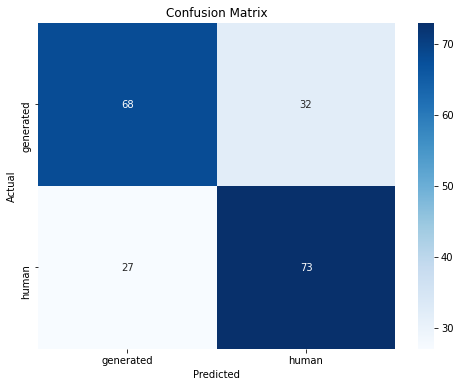

In [34]:
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix
from transformers import BertTokenizer, BertModel
import torch
import seaborn as sns
import matplotlib.pyplot as plt


def train_cv_svm(df, n_splits=5):
    """
    function that receives a dataframe and trains a support vector machine
    classification mother using get_bert_embeddings
    
    it additionally uses a cross validation scheme to check results
    """

    
    # Upload multilingual BERT
    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
    model = BertModel.from_pretrained('bert-base-multilingual-cased')
    
    # Getting word embeddings
    X_embeddings = [get_bert_embeddings(text, tokenizer, model) for text in df['text']]
    X_embeddings = [embedding.squeeze() for embedding in X_embeddings]
    
    # SVM model
    svm_model = SVC(kernel='linear')
    
    # Cross validation
    y_pred = cross_val_predict(svm_model, X_embeddings, df['label'], cv=n_splits)
    
    f1 = f1_score(df['label'], y_pred, average='weighted')
    print("F1 Score:", f1)
    
    cm = confusion_matrix(df['label'], y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # Get confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['generated', 'human'], yticklabels=['generated', 'human'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


df = sampling(train_gl, 100)

train_cv_svm(df)


### Second approach using `Multilingual BERT`

In [24]:
def identify_domain(text):
    # Keywords for each domain in Galician
    keywords = {
        'technology': ['tecnoloxía', 'informática', 'software', 'intelixencia artificial', 'computación'],
        'health': ['saúde', 'médico', 'enfermidades', 'tratamento', 'medicina'],
        'legal': ['lei', 'legal', 'xurídico', 'avogado', 'dereito'],
        'politics': ['política', 'goberno', 'eleccións', 'partido', 'democracia'],
        'philosophy': ['filosofía', 'metafísica', 'ética', 'epistemoloxía', 'lóxica'],
        'language': ['lingua', 'idioma', 'gramática', 'vocabulario', 'lingüística'],
        'art': ['arte', 'pintura', 'música', 'escultura', 'dança'],
        'biology': ['bioloxía', 'biolóxico', 'organismo', 'célula', 'xenética'],
        'education': ['educación', 'escola', 'alumno', 'profesor', 'aprendizaxe'],
        'geography': ['xeografía', 'continente', 'oceano', 'rexión', 'paisaxe'],
        'economy': ['economía', 'finanzas', 'mercado', 'comercio', 'negocio'],
        'religion': ['relixión', 'creencia', 'fe', 'igrexa', 'espiritualidade']
    }
    
    # Initialize a dictionary to count the occurrence of keywords in the text
    keyword_count = {domain: 0 for domain in keywords}
    
    # Count occurrences of keywords in the text
    for domain, domain_keywords in keywords.items():
        keyword_count[domain] = sum(1 for keyword in domain_keywords if keyword in text.lower())
    
    # Get the domain with the maximum count of keywords
    predicted_domain = max(keyword_count, key=keyword_count.get)
    
    return predicted_domain

# Example usage:
text_example = "A intelixencia artificial está a revolucionar a industria tecnolóxica."
domain = identify_domain(text_example)
print("The text belongs to the domain of:", domain)


The text belongs to the domain of: technology


**NOTE**

I tried using stemmer but there's no official stemmer for Galician. I tried with the Portuguese one but the results weren't so good. 

I also tried different ways of adding domain to a row (without the need of being anotators) and this works quite fine in comparation to the others. 

In [25]:
train_gl['domain'] = train_gl['text'].apply(identify_domain)

In [26]:
train_gl['domain'].value_counts()

domain
technology    3256
religion      2136
art           1633
legal         1237
politics      1075
education      544
language       473
health         350
philosophy     325
geography      283
economy        241
biology         72
Name: count, dtype: int64

In [27]:
import pandas as pd

def domain_sampling(df, n):
    """
    Sample n rows of each domain from the DataFrame.

    Parameters:
    - df: DataFrame containing text data and corresponding labels.
    - n: Number of rows to sample for each domain.

    Returns:
    - sampled_df: DataFrame containing n rows of each domain.
    """
    # Dict where I'll put the sampled rows
    sampled_data = {}
    

    for domain in df['domain'].unique():
        sampled_data[domain] = df[df['domain'] == domain].sample(n, replace=True)
    
    sampled_df = pd.concat(sampled_data.values())
    sampled_df = sampled_df.sample(frac=1).reset_index(drop=True)
    
    return sampled_df

# This number comes from the lowest number of rows belonging to a domain
n = 72  
sampled_df = domain_sampling(train_gl, n)


In [28]:
sampled_df

,text,label,detected_language,domain
0,"Todo-los santos que son no ceo, xa non están a...",generated,gl,religion
1,A copa da raíña de hóckey a patíns é a segunda...,human,gl,religion
2,O potasio é un elemento químico da táboa perió...,human,gl,biology
3,"A atrazina é un herbicida de tipo triazina, us...",human,gl,religion
4,O concello de zas foi sancionado con unha mult...,generated,gl,biology
...,...,...,...,...
847,"De por que nas follas se xoga, e macar home po...",generated,gl,legal
848,"""embarcación (homónimos)"" é un termo que pode ...",generated,gl,legal
849,"Creo que é unha boa entrevista, pero hai un pe...",generated,gl,education
850,Os expertos piden multilingüismo e convivencia...,generated,gl,language


In [29]:
# Use these new data with the sample
train_test_svm(sampled_df)

F1 Score: 0.8234631018934238


F1 Score: 0.8427126046113866
Confusion Matrix:
[[357  73]
 [ 61 361]]


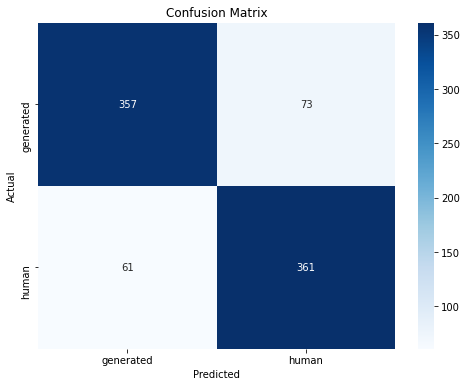

In [30]:
from sklearn.model_selection import StratifiedGroupKFold, cross_val_predict
from sklearn.metrics import f1_score, confusion_matrix
from transformers import BertTokenizer, BertModel
import torch
import seaborn as sns
import matplotlib.pyplot as plt

def get_bert_embeddings(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.numpy()

def train_cv_svm(df, n_splits=5):
    # Load the BERT model and tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
    model = BertModel.from_pretrained('bert-base-multilingual-cased')
    
    # Get the BERT embeddings for the entire dataframe
    X_embeddings = [get_bert_embeddings(text, tokenizer, model) for text in df['text']]
    X_embeddings = [embedding.squeeze() for embedding in X_embeddings]
    
    # Initialize the SVM model
    svm_model = SVC(kernel='linear')
    
    # Initialize the Stratified Group K-Fold
    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    
    # Perform cross-validation and get predictions
    y_pred = cross_val_predict(svm_model, X_embeddings, df['label'], cv=sgkf.split(X_embeddings, df['label'], groups=df['domain']))
    
    # Calculate the F1 score of the model
    f1 = f1_score(df['label'], y_pred, average='weighted')
    print("F1 Score:", f1)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(df['label'], y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # Visualize the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['generated', 'human'], yticklabels=['generated', 'human'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# call function:
train_cv_svm(sampled_df, n_splits=5)


**NOTE**

There is a BERT model trained with Galician texts called BERTINHO (dvilares/bertinho-gl-base-cased)
